In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Preprocessing

### Importing Libraries

In [ ]:
!pip install chart_studio

In [ ]:
#importing all libraries
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences
import os
import re
import numpy as np
import pandas as pd
import chart_studio.plotly as py
import plotly.graph_objs as go
import itertools
from scipy import stats
from ast import literal_eval
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Input, Activation, GlobalAveragePooling1D, Flatten, Concatenate, Conv1D, MaxPooling1D,Bidirectional,TimeDistributed,Reshape,Conv2D,MaxPool2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import concatenate
from tensorflow.keras.optimizers import SGD, RMSprop, Adagrad, Adam
from tensorflow.keras.preprocessing.text import one_hot, text_to_word_sequence, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model

import fnmatch

import warnings

import string
from pathlib import Path
from random import shuffle
from ast import literal_eval

warnings.filterwarnings('ignore')

In [ ]:
#!pip install nltk
import nltk

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

from nltk.stem.wordnet import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
import gensim
import json


import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import plot_model
import tensorflow.keras.utils
from tensorflow.keras import utils as np_utils

#Keras Tokenizer just replaces certain punctuation characters and splits on the remaining space character.
#NLTK Tokenizer uses the Treebank tokenizer uses regular expressions to tokenize text as in Penn Treebank. 

In [ ]:

WINDOWS_SIZE = 10
labels=['none','mild','moderate','moderately severe', 'severe']
num_classes = len(labels)

### Creating a dataframe from the transcript file

In [ ]:
def transcripts_to_dataframe(directory):
    rows_list = []
        
    filenames = os.listdir(directory)
    
    if ".DS_Store" in filenames:
        filenames.remove(".DS_Store")
        
    for filename in filenames:
        transcript_path = os.path.join(directory, filename)
        transcript = pd.read_csv(transcript_path, sep='\t')
        m = re.search("(\d{3})_TRANSCRIPT.csv", filename)
        if m:
            person_id = m.group(1)
            p = {}
            question = ""
            answer = ""
            lines = len(transcript)
            for i in range(0, lines):
                row = transcript.iloc[i]
                if (row["speaker"] == "Ellie") or (i == lines - 1):
                    p["personId"] = person_id
                    if "(" in str(question):
                        question = question[question.index("(") + 1:question.index(")")]
                    p["question"] = question
                    p["answer"] = answer
                    if question != "":
                        rows_list.append(p)
                    p = {}
                    answer = ""
                    question = row["value"]
                else:
                    answer = str(answer) + " " + str(row["value"])

    all_participants = pd.DataFrame(rows_list, columns=['personId', 'question', 'answer'])
    all_participants.to_csv(directory + 'all.csv', sep=',')
    print("File was created")
    return all_participants

In [ ]:
#loading the data
data_path = "/content/drive/My Drive/transcripts/"
all_participants = transcripts_to_dataframe(data_path)

File was created


In [ ]:
all_participants.head(20)

,personId,question,answer
0,301,hi i'm ellie thanks for coming in today i was ...,thank you
1,301,think of me as a friend i don't judge i can't ...,mmm k
2,301,i'm here to learn about people and would love ...,
3,301,how are you doing today,i'm doing good thank you
4,301,that's good,
5,301,where are you from originally,i'm from los angeles
6,301,really me too,oh great
7,301,where do you live,i live in west los angeles the west side
8,301,nice,
9,301,how do you like your living situation,it's alright i xxx


### Removing the stopwords and cleaning the data

In [ ]:
#https://www.kaggle.com/currie32/the-importance-of-cleaning-text

def text_to_wordlist(text, remove_stopwords=True, stem_words=False):    
    # Clean the text, with the option to remove stopwords and to stem words.
    
    # Convert words to lower case and split them
    text = text.lower().split()

    # Optionally, remove stop words
    if remove_stopwords:
        stops = stopwords.words("english")
        text = [wordnet_lemmatizer.lemmatize(w) for w in text if not w in stops ]
        text = [w for w in text if w != "nan" ]
    else:
        text = [wordnet_lemmatizer.lemmatize(w) for w in text]
        text = [w for w in text if w != "nan" ]
    
    text = " ".join(text)

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    
    text = re.sub(r"\<", " ", text)
    text = re.sub(r"\>", " ", text)
    
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    
    # Optionally, shorten words to their stems
    if stem_words:
        text = text.split()
        stemmer = SnowballStemmer('english')
        stemmed_words = [stemmer.stem(word) for word in text]
        text = " ".join(stemmed_words)
    
    # Return a list of words
    return(text)

In [ ]:
#creating a corpus with the words from the answers without stopwords given by the patients
all_participants_mix = all_participants.copy() # However, if you need the original list unchanged when the new list is modified, you can use copy() method. This is called shallow copy.
all_participants_mix['answer'] = all_participants_mix.apply(lambda row: text_to_wordlist(row.answer).split(), axis=1)

In [ ]:
##creating a corpus with the words from the answers withstopwords given by the patients
# stopwords are ={what is , have,}
all_participants_mix_stopwords = all_participants.copy()
all_participants_mix_stopwords['answer'] = all_participants_mix_stopwords.apply(lambda row: text_to_wordlist(row.answer, remove_stopwords=False).split(), axis=1)


In [ ]:
words = [w for w in all_participants_mix['answer'].tolist()]
words = set(itertools.chain(*words)) #chain('ABC', 'DEF') --> A B C D E F
vocab_size = len(words)

### Getting the top common words used by the patients

In [ ]:
words

{'early',
 'smile',
 'watch',
 'tie',
 'lawsuit',
 'mountain',
 'adjusted',
 'originally',
 'never',
 'soccer',
 'career',
 'traveling',
 'rough',
 'example',
 'cut',
 'separated',
 'bitch',
 'distance',
 't',
 'short',
 'hoped',
 'college',
 'unfortunately',
 'able',
 'shoulda',
 'four',
 'harder',
 'using',
 'anywhere',
 'issue',
 'disrespected',
 'fine',
 'xxx',
 'way',
 'regret',
 'youngest',
 'picture',
 'communicate',
 'living',
 'packed',
 'restaurant',
 'it',
 'hit',
 'came',
 'wow',
 'knowledge',
 'environment',
 'happen',
 'fall',
 'hollywood',
 'sniffle',
 'completely',
 'right',
 'hard',
 'healthy',
 'pat',
 'mm',
 'peaceful',
 'hiking',
 'listen',
 'across',
 '-',
 'girlfriend',
 'tiger',
 'suicide',
 'island',
 'america',
 'average',
 'cover',
 'head',
 'sleep',
 'aggressive',
 'today',
 'afghanistan',
 'motivated',
 'bos',
 'determined',
 'grumpy',
 'live',
 'waste',
 'varies',
 'scenery',
 'label',
 'soul',
 'note',
 'wonder',
 'mmm',
 'diagnose',
 'dad',
 'sociology',


In [ ]:
words_stop = [w for w in all_participants_mix_stopwords['answer'].tolist()]
words_stop = set(itertools.chain(*words_stop))
vocab_size_stop = len(words_stop)

In [ ]:
words_stop

{'early',
 'smile',
 'watch',
 'tie',
 'lawsuit',
 'mountain',
 'adjusted',
 'while',
 'originally',
 'never',
 'soccer',
 'career',
 'traveling',
 'rough',
 'example',
 'cut',
 'separated',
 'bitch',
 'distance',
 't',
 'short',
 'hoped',
 'college',
 'unfortunately',
 'able',
 'shoulda',
 'four',
 'harder',
 'using',
 'anywhere',
 'issue',
 'disrespected',
 'fine',
 'xxx',
 'some',
 'way',
 'regret',
 'youngest',
 'picture',
 'communicate',
 'living',
 'packed',
 'restaurant',
 'it',
 'hit',
 'came',
 'wow',
 'knowledge',
 'environment',
 'happen',
 'fall',
 'hollywood',
 'sniffle',
 'completely',
 'right',
 'hard',
 'healthy',
 'pat',
 'mm',
 'peaceful',
 'hiking',
 'listen',
 'across',
 '-',
 'girlfriend',
 'tiger',
 'suicide',
 'island',
 'america',
 'average',
 'cover',
 'further',
 'head',
 'sleep',
 'aggressive',
 'today',
 'afghanistan',
 'motivated',
 'bos',
 'determined',
 'just',
 'with',
 'live',
 'grumpy',
 'waste',
 'varies',
 'scenery',
 'label',
 'soul',
 'note',
 'won

In [ ]:
windows_size = WINDOWS_SIZE
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(all_participants_mix['answer']) # fit_on_texts creates the vocabulary index based on word frequency.
#The cat sat on the mat." It will create a dictionary s.t. word_index["the"] = 1; word_index["cat"] = 2 it is word -> index dictionary so every word gets a unique integer value. 0 is reserved for padding. So lower integer means more frequent word 

tokenizer.fit_on_sequences(all_participants_mix['answer']) #texts_to_sequences Transforms each text in texts to a sequence of integers. So it basically takes each word in the text and replaces it with its corresponding integer value from the word_index dictionary.

all_participants_mix['t_answer'] = tokenizer.texts_to_sequences(all_participants_mix['answer'])
all_participants_mix.head(15)

#   why are the output as numbers when text_to_sequences is called?
# the Tokenizer stores everything in the word_index during fit_on_texts. Then, when calling the texts_to_sequences method, only the top num_words are considered.

,personId,question,answer,t_answer
0,301,hi i'm ellie thanks for coming in today i was ...,[thank],[98]
1,301,think of me as a friend i don't judge i can't ...,"[mmm, k]","[356, 760]"
2,301,i'm here to learn about people and would love ...,[],[]
3,301,how are you doing today,"[i, am, good, thank]","[4, 6, 12, 98]"
4,301,that's good,[],[]
5,301,where are you from originally,"[i, am, los, angeles]","[4, 6, 144, 197]"
6,301,really me too,"[oh, great]","[50, 130]"
7,301,where do you live,"[live, west, los, angeles, west, side]","[113, 494, 144, 197, 494, 357]"
8,301,nice,[],[]
9,301,how do you like your living situation,"[alright, xxx]","[162, 761]"


In [ ]:
import pickle
with open('./tokenizer.pickle', 'wb') as f:
    pickle.dump(tokenizer, f)

In [ ]:

windows_size = WINDOWS_SIZE
tokenizer = Tokenizer(num_words=vocab_size_stop)
tokenizer.fit_on_texts(all_participants_mix_stopwords['answer'])
tokenizer.fit_on_sequences(all_participants_mix_stopwords['answer'])

all_participants_mix_stopwords['t_answer'] = tokenizer.texts_to_sequences(all_participants_mix_stopwords['answer'])
all_participants_mix_stopwords.head(15)

,personId,question,answer,t_answer
0,301,hi i'm ellie thanks for coming in today i was ...,"[thank, you]","[165, 5]"
1,301,think of me as a friend i don't judge i can't ...,"[mmm, k]","[440, 850]"
2,301,i'm here to learn about people and would love ...,[],[]
3,301,how are you doing today,"[i, am, doing, good, thank, you]","[1, 19, 100, 38, 165, 5]"
4,301,that's good,[],[]
5,301,where are you from originally,"[i, am, from, los, angeles]","[1, 19, 91, 221, 278]"
6,301,really me too,"[oh, great]","[101, 205]"
7,301,where do you live,"[i, live, in, west, los, angeles, the, west, s...","[1, 186, 22, 583, 221, 278, 10, 583, 441]"
8,301,nice,[],[]
9,301,how do you like your living situation,"[it, alright, i, xxx]","[2, 240, 1, 851]"


In [ ]:
word_index = tokenizer.word_index
word_size = len(word_index)
print(word_index["sad"])


672


# Data Augmentation of the tokenized words to improve model performance

In [ ]:
#windows_size = WINDOWS_SIZE
#cont = 0
#word_index = tokenizer
#phrases_lp = pd.DataFrame(columns=['personId','answer','t_answer'])
#answers = all_participants_mix.groupby('personId').agg('sum', axis=1)

#for p in answers.iterrows():      
    #words = p[1]["answer"]
    #size = len(words)
    #word_tokens = p[1]["t_answer"]
 
    #for i in range(size):
        #sentence = words[i:min(i+windows_size,size)]  
        #tokens = word_tokens[i:min(i+windows_size,size)]  
        #phrases_lp.loc[cont] = [p[0], sentence, tokens]
        #cont = cont + 1

In [ ]:
#phrases_lp.head()
#phrases_lp.to_csv('/content/drive/My Drive/Final-year-project-Phase2/phrases_lp.csv', sep='\t')
#print("File was created")

In [ ]:
#phrases_lp["t_answer"] = pad_sequences(phrases_lp["t_answer"], value=0, padding="post", maxlen=windows_size).tolist()
#phrases_lp.drop(phrases_lp[phrases_lp["t_answer"].map(len) > 10].index, inplace = True)


In [ ]:
#phrases_lp_stop.to_csv('/content/drive/My Drive/Final-year-project-Phase2/phrases_lp_stop.csv', sep='\t')
#print("File was created")

### Loading the data augmented dataset

In [ ]:
phrases_lp = pd.read_csv('/content/drive/My Drive/Final-year-project-Phase 2/phrases_lp.csv', sep='\t', converters={"t_answer": literal_eval}) 
phrases_lp.head(15)


,Unnamed: 0,personId,answer,t_answer
0,0,300,"['good', 'atlanta', 'georgia', 'um', 'my', 'pa...","[38, 960, 961, 12, 18, 266, 36, 91, 88, 12]"
1,1,300,"['atlanta', 'georgia', 'um', 'my', 'parent', '...","[960, 961, 12, 18, 266, 36, 91, 88, 12, 1]"
2,2,300,"['georgia', 'um', 'my', 'parent', 'are', 'from...","[961, 12, 18, 266, 36, 91, 88, 12, 1, 138]"
3,3,300,"['um', 'my', 'parent', 'are', 'from', 'here', ...","[12, 18, 266, 36, 91, 88, 12, 1, 138, 2]"
4,4,300,"['my', 'parent', 'are', 'from', 'here', 'um', ...","[18, 266, 36, 91, 88, 12, 1, 138, 2, 1]"
5,5,300,"['parent', 'are', 'from', 'here', 'um', 'i', '...","[266, 36, 91, 88, 12, 1, 138, 2, 1, 15]"
6,6,300,"['are', 'from', 'here', 'um', 'i', 'love', 'it...","[36, 91, 88, 12, 1, 138, 2, 1, 15, 10]"
7,7,300,"['from', 'here', 'um', 'i', 'love', 'it', 'i',...","[91, 88, 12, 1, 138, 2, 1, 15, 10, 241]"
8,8,300,"['here', 'um', 'i', 'love', 'it', 'i', 'like',...","[88, 12, 1, 138, 2, 1, 15, 10, 241, 1]"
9,9,300,"['um', 'i', 'love', 'it', 'i', 'like', 'the', ...","[12, 1, 138, 2, 1, 15, 10, 241, 1, 15]"


### Loading the train, validation and test data containing the PHQ Scores

In [ ]:
from tensorflow.keras.utils import to_categorical
def load_avec_dataset_file(path,score_column):
    ds = pd.read_csv(path, sep=',')
    ds['level'] = pd.cut(ds[score_column], bins=[-1,0,5,10,15,25], labels=[0,1,2,3,4])  #cut function used to segregate array into bins 5 levels - 'none','mild','moderate','moderately severe', 'severe'
    ds['PHQ8_Score'] = ds[score_column]
    ds['cat_level'] = to_categorical(ds['level'], num_classes).tolist() #categorical levels 
    ds = ds[['Participant_ID', 'level', 'cat_level', 'PHQ8_Score','Gender']] 
    ds = ds.astype({"Participant_ID": float, "level": int, 'PHQ8_Score': int})
    return ds

In [ ]:
train = load_avec_dataset_file('/content/drive/My Drive/Depression_detect/train_split_Depression_AVEC2017 (1).csv','PHQ8_Score')
dev = load_avec_dataset_file('/content/drive/My Drive/Depression_detect/dev_split_Depression_AVEC2017.csv','PHQ8_Score')
test = load_avec_dataset_file('/content/drive/My Drive/Depression_detect/full_test_split.csv','PHQ8_Score')
print("Size: train= {}, dev= {}, test={}".format(len(train), len(dev), len(test)))
train.head()


Size: train= 107, dev= 35, test=47


,Participant_ID,level,cat_level,PHQ8_Score,Gender
0,303.0,0,"[1.0, 0.0, 0.0, 0.0, 0.0]",0,0
1,304.0,2,"[0.0, 0.0, 1.0, 0.0, 0.0]",6,0
2,305.0,2,"[0.0, 0.0, 1.0, 0.0, 0.0]",7,1
3,310.0,1,"[0.0, 1.0, 0.0, 0.0, 0.0]",4,1
4,312.0,1,"[0.0, 1.0, 0.0, 0.0, 0.0]",2,1


In [ ]:
ds_total = pd.concat([dev,train,test])
total_phq8 = len(ds_total)
print("Total size = {}".format(total_phq8))

Total size = 189


In [ ]:

ds_total

,Participant_ID,level,cat_level,PHQ8_Score,Gender
0,302.0,1,"[0.0, 1.0, 0.0, 0.0, 0.0]",4,1
1,307.0,1,"[0.0, 1.0, 0.0, 0.0, 0.0]",4,0
2,331.0,2,"[0.0, 0.0, 1.0, 0.0, 0.0]",8,1
3,335.0,3,"[0.0, 0.0, 0.0, 1.0, 0.0]",12,0
4,346.0,4,"[0.0, 0.0, 0.0, 0.0, 1.0]",23,0
...,...,...,...,...,...
42,467.0,0,"[1.0, 0.0, 0.0, 0.0, 0.0]",0,1
43,469.0,1,"[0.0, 1.0, 0.0, 0.0, 0.0]",3,0
44,470.0,1,"[0.0, 1.0, 0.0, 0.0, 0.0]",3,0
45,480.0,1,"[0.0, 1.0, 0.0, 0.0, 0.0]",1,1


In [ ]:
ds_total.to_csv('/content/drive/My Drive/Depression_detect/ds_total.csv', sep='\t')
print("File was created")

File was created


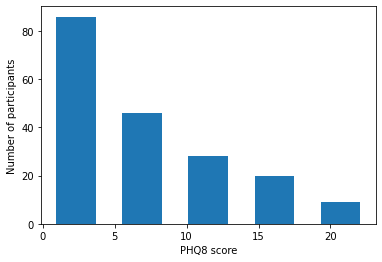

<Figure size 432x288 with 0 Axes>

In [ ]:
bins=[-1,0,5,10,15,25]
plt.figure()
plt.hist(ds_total["PHQ8_Score"], rwidth=0.6, bins=5)
plt.xlabel('PHQ8 score')
plt.ylabel('Number of participants')
plt.show()
plt.savefig('/content/drive/My Drive/Depression_detect/bins.png')


### Splitting the dataset and grouping them based on the 5 different level

In [ ]:
def split_by_phq_level(ds):
    none_ds = ds[ds['level']==0]
    mild_ds = ds[ds['level']==1]
    moderate_ds = ds[ds['level']==2]
    moderate_severe_ds = ds[ds['level']==3]
    severe_ds = ds[ds['level']==4]
    return (none_ds, mild_ds, moderate_ds, moderate_severe_ds, severe_ds)

In [ ]:
none_ds, mild_ds, moderate_ds, moderate_severe_ds, severe_ds = split_by_phq_level(ds_total)
print("Quantity per none_ds: {}, mild_ds: {}, moderate_ds {}, moderate_severe_ds: {}, severe_ds {}".format(len(none_ds), len(mild_ds), len(moderate_ds), len(moderate_severe_ds), len(severe_ds)))

Quantity per none_ds: 26, mild_ds: 70, moderate_ds 47, moderate_severe_ds: 24, severe_ds 22


In [ ]:
b_none_ds = ds_total[ds_total['level']==0]
b_mild_ds = ds_total[ds_total['level']==1].sample(26)
b_moderate_ds = ds_total[ds_total['level']==2].sample(26)
b_moderate_severe_ds = ds_total[ds_total['level']==3]
b_severe_ds = ds_total[ds_total['level']==4]

ds_total_b = pd.concat([b_none_ds, b_mild_ds, b_moderate_ds, b_moderate_severe_ds, b_severe_ds])

In [ ]:
ds_= ds_total_b.to_csv('ds_total_b.csv')

### Merging the phrases_lp (consisting of the transcripts) and ds_total consisting of PHQ Score

In [ ]:
ds_lp = pd.merge(ds_total, phrases_lp,left_on='Participant_ID', right_on='personId')
ds_lp.drop(ds_lp[ds_lp["t_answer"].map(len) < 10].index, inplace = True)
ds_lp_b = pd.merge(ds_total_b, phrases_lp,left_on='Participant_ID', right_on='personId')
ds_lp_b.drop(ds_lp_b[ds_lp_b["t_answer"].map(len) < 10].index, inplace = True)

In [ ]:
#ds_lp["t_answer"][142810]

In [ ]:
(len(ds_lp))

14887

### Splitting ds_total into train, dev and test in the ratio of 70:14:16

In [ ]:
def distribute_instances(ds, split_in = [70,14,16]):
    ds_shuffled = ds.sample(frac=1)
    none_ds, mild_ds, moderate_ds, moderate_severe_ds, severe_ds = split_by_phq_level(ds_shuffled)
    eq_ds = dict()
    prev_none = prev_mild = prev_moderate = prev_moderate_severe = prev_severe = 0
    split = split_in
    for p in split:
        last_none = min(len(none_ds), prev_none + round(len(none_ds) * p/100))
        last_mild = min(len(mild_ds), prev_mild + round(len(mild_ds) * p/100))
        last_moderate = min(len(moderate_ds), prev_moderate + round(len(moderate_ds) * p/100))
        last_moderate_severe = min(len(moderate_severe_ds), prev_moderate_severe + round(len(moderate_severe_ds) * p/100))
        last_severe = min(len(severe_ds), prev_severe + round(len(severe_ds) * p/100))  
        eq_ds['d'+str(p)] = pd.concat([none_ds[prev_none: last_none], mild_ds[prev_mild: last_mild], moderate_ds[prev_moderate: last_moderate], moderate_severe_ds[prev_moderate_severe: last_moderate_severe], severe_ds[prev_severe: last_severe]])
        prev_none = last_none
        prev_mild = last_mild
        prev_moderate = last_moderate
        prev_moderate_severe = last_moderate_severe
        prev_severe = last_severe  
    return (eq_ds['d70'], eq_ds['d14'], eq_ds['d16'])

In [ ]:

train_lp, dev_lp, test_lp = distribute_instances(ds_lp)
train_lp_b, dev_lp_b, test_lp_b = distribute_instances(ds_lp_b)

### Creating a confusion matrix which consists of the TPs, TNs, FPs and FNs of the predicted labels for the transcripts

In [ ]:
def confusion_matrix(model, x, y):
    prediction = model.predict(x, batch_size=None, verbose=0, steps=None)
    labels=['none','mild','moderate','moderately severe', 'severe']

    max_prediction = np.argmax(prediction, axis=1)
    
    max_actual = np.argmax(y, axis=1)

    y_pred = pd.Categorical.from_codes(max_prediction, labels)
    y_actu = pd.Categorical.from_codes(max_actual, labels)

    return pd.crosstab(y_actu, y_pred)

### Loading the Glove Embeddings into a file and putting each vector into an np array

In [ ]:
embeddings_index = dict()
f = open('/content/drive/My Drive/glove.6B.100d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()


### Creating a embedding matrix

In [ ]:

def fill_embedding_matrix(tokenizer):
    vocab_size = len(tokenizer.word_index) # tokenizer.word_index is the list that consist of all the unique words
    embedding_matrix = np.zeros((vocab_size+1, 100)) # creating an embedding matrix
    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:        
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

### calling the embedding matrix function for creating vectors for each unique word

In [ ]:
embedding_matrix_lp = fill_embedding_matrix(tokenizer)
embedding_matrix_lp.shape

(1580, 100)

In [ ]:
train_lp['t_answer']
train_lp.head()

,Participant_ID,level,cat_level,PHQ8_Score,Gender,Unnamed: 0,personId,answer,t_answer
12074,306.0,0,"[1.0, 0.0, 0.0, 0.0, 0.0]",0,0,9402,306,"['job', 'and', 'the', 'work', 'uh', 'i', 'thin...","[61, 3, 10, 63, 7, 1, 33, 2, 446, 1]"
3372,303.0,0,"[1.0, 0.0, 0.0, 0.0, 0.0]",0,0,2610,303,"['so', 'you', 'can', 'you', 'know', 'look', 'o...","[14, 5, 67, 5, 9, 223, 58, 6, 87, 39]"
11863,306.0,0,"[1.0, 0.0, 0.0, 0.0, 0.0]",0,0,9191,306,"['can', 'use', 'uh', 'you', 'know', 'skill', '...","[67, 752, 7, 5, 9, 734, 6, 40, 255, 6]"
12894,306.0,0,"[1.0, 0.0, 0.0, 0.0, 0.0]",0,0,10222,306,"['damage', 'to', 'our', 'life', 'my', 'daughte...","[1319, 6, 306, 77, 18, 173, 77, 1, 7, 11]"
3657,303.0,0,"[1.0, 0.0, 0.0, 0.0, 0.0]",0,0,2895,303,"['driving', 'for', 'year', 'and', 'dealing', '...","[242, 26, 57, 3, 334, 25, 10, 650, 14, 2]"


In [ ]:
train_a =np.stack(train_lp['t_answer'])
dev_a = np.stack(dev_lp['t_answer'])
train_y = np.stack(train_lp['cat_level'], axis=0)
dev_y = np.stack(dev_lp['cat_level'], axis=0)

In [ ]:
dev_a.shape

(2084, 10)

### stacking all the arrays together to form a single array

In [ ]:
train_a_b = np.stack(train_lp_b['t_answer'], axis=0)
dev_a_b = np.stack(dev_lp_b['t_answer'], axis=0)
train_y_b = np.stack(train_lp_b['cat_level'], axis=0)
dev_y_b = np.stack(dev_lp_b['cat_level'], axis=0)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

### creating function for plotting the loss and accuracies of the models

In [ ]:
def plot_acc(history, title="Model Accuracy"):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
    
def plot_loss(history, title="Model Loss"):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.show()
    
def plot_compare_losses(history1, history2, name1="Red 1", name2="Red 2", title="Graph title"):
    plt.plot(history1.history['loss'], color="green")
    plt.plot(history1.history['val_loss'], 'r--', color="green")
    plt.plot(history2.history['loss'], color="blue")
    plt.plot(history2.history['val_loss'], 'r--', color="blue")
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train ' + name1, 'Val ' + name1, 
                'Train ' + name2, 'Val ' + name2],
               loc='upper right')
    plt.show()
    
def plot_compare_accs(history1, history2, name1="Red 1",
                      name2="Red 2", title="Graph title"):
    """Compara accuracies de dos entrenamientos con nombres name1 y name2"""
    plt.plot(history1.history['acc'], color="green")
    plt.plot(history1.history['val_acc'], 'r--', color="green")
    plt.plot(history2.history['acc'], color="blue")
    plt.plot(history2.history['val_acc'], 'r--', color="blue")
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train ' + name1, 'Val ' + name1, 
                'Train ' + name2, 'Val ' + name2], 
               loc='lower right')
    plt.show()

def plot_compare_multiple_metrics(history_array, names, colors, title="Graph title", metric='acc'):  
    legend = []
    for i in range(0, len(history_array)):
        plt.plot(history_array[i].history[metric], color=colors[i])
        plt.plot(history_array[i].history['val_' + metric], 'r--', color=colors[i])
        legend.append('Train ' + names[i])
        legend.append('Val ' + names[i])
    
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')   
    plt.axis
    plt.legend(legend, 
               loc='lower right')
    plt.show()

In [ ]:

early_stopping = EarlyStopping(monitor='val_loss', patience=3)

### answer_emb1 is the input consisting of the vectors having a window size of 10

In [ ]:
answer_inp = Input(shape=(windows_size, ))
embedding_size_glove = 100
answer_emb1 = Embedding(vocab_size_stop+1, embedding_size_glove, weights=[embedding_matrix_lp], input_length=windows_size, trainable=False)(answer_inp)



### GLoVE + LSTM MODEL

In [ ]:
bt = BatchNormalization()(answer_emb1)
lstm = LSTM(embedding_size_glove, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)(bt)

dense1 = Dense(units=256, activation="relu")(lstm)
dense2 = Dense(units=256, activation="relu")(dense1)

flatten = Flatten()(dense2)

out = Dense(5,  activation='softmax')(flatten)

model = Model(inputs=[answer_inp], outputs=[out])
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 10, 100)           158000    
_________________________________________________________________
batch_normalization (BatchNo (None, 10, 100)           400       
_________________________________________________________________
lstm (LSTM)                  (None, 10, 100)           80400     
_________________________________________________________________
dense (Dense)                (None, 10, 256)           25856     
_________________________________________________________________
dense_1 (Dense)              (None, 10, 256)           65792     
_________________________________________________________________
flatten (Flatten)            (None, 2560)              0     

In [ ]:
model_glove_lstm_hist = model.fit(train_a, train_y, validation_data=(dev_a, dev_y), epochs=30, batch_size=64, shuffle=True, callbacks=[early_stopping])

Epoch 1/30
163/163 [==============================] - 7s 44ms/step - loss: 1.1867 - accuracy: 0.5098 - val_loss: 1.0015 - val_accuracy: 0.5931
Epoch 2/30
163/163 [==============================] - 7s 41ms/step - loss: 0.7431 - accuracy: 0.7181 - val_loss: 0.4773 - val_accuracy: 0.8306
Epoch 3/30
163/163 [==============================] - 7s 41ms/step - loss: 0.4286 - accuracy: 0.8392 - val_loss: 0.2749 - val_accuracy: 0.8978
Epoch 4/30
163/163 [==============================] - 7s 41ms/step - loss: 0.2482 - accuracy: 0.9080 - val_loss: 0.1487 - val_accuracy: 0.9477
Epoch 5/30
163/163 [==============================] - 7s 41ms/step - loss: 0.1848 - accuracy: 0.9310 - val_loss: 0.1070 - val_accuracy: 0.9664
Epoch 6/30
163/163 [==============================] - 7s 41ms/step - loss: 0.1380 - accuracy: 0.9499 - val_loss: 0.0770 - val_accuracy: 0.9741
Epoch 7/30
163/163 [==============================] - 7s 41ms/step - loss: 0.0983 - accuracy: 0.9664 - val_loss: 0.0594 - val_accuracy: 0.9794

In [ ]:
#model.save('./model2',save_format='tf')
model.save('model_glove_lstm.h5')

In [ ]:
test_a = np.stack(test_lp['t_answer'], axis=0)
test_y = np.stack(test_lp['cat_level'], axis=0)
test_a_b = np.stack(test_lp_b['t_answer'], axis=0)
test_y_b = np.stack(test_lp_b['cat_level'], axis=0)
df_confusion1 = confusion_matrix(model, test_a, test_y)

In [ ]:
df_confusion1

col_0,none,mild,moderate,moderately severe,severe
row_0,,,,,
none,578,1,1,0,0
mild,1,824,1,2,0
moderate,5,8,699,0,0
moderately severe,0,0,0,115,0
severe,0,1,0,0,147


In [ ]:
score = model.evaluate(test_a, test_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.02326219528913498
Test accuracy: 0.9916071891784668


In [ ]:
"""
from sklearn.externals import joblib
joblib.dump(model,"model.pkl"),
"""

'\nfrom sklearn.externals import joblib\njoblib.dump(model,"model.pkl"),\n'

## **LSTM Model for the balanced dataset**

In [ ]:
model_glove_lstm_hist_b = model.fit(train_a_b, train_y_b, validation_data=(dev_a_b, dev_y_b), epochs=30, batch_size=64, shuffle=True, callbacks=[early_stopping])

Epoch 1/30
102/102 [==============================] - 4s 42ms/step - loss: 0.0565 - accuracy: 0.9818 - val_loss: 0.0057 - val_accuracy: 0.9992
Epoch 2/30
102/102 [==============================] - 4s 42ms/step - loss: 0.0347 - accuracy: 0.9870 - val_loss: 0.0050 - val_accuracy: 0.9977
Epoch 3/30
102/102 [==============================] - 4s 41ms/step - loss: 0.0331 - accuracy: 0.9884 - val_loss: 0.0050 - val_accuracy: 0.9985
Epoch 4/30
102/102 [==============================] - 4s 41ms/step - loss: 0.0263 - accuracy: 0.9908 - val_loss: 0.0045 - val_accuracy: 0.9977
Epoch 5/30
102/102 [==============================] - 4s 41ms/step - loss: 0.0161 - accuracy: 0.9959 - val_loss: 0.0027 - val_accuracy: 0.9985
Epoch 6/30
102/102 [==============================] - 4s 41ms/step - loss: 0.0191 - accuracy: 0.9936 - val_loss: 0.0025 - val_accuracy: 0.9985
Epoch 7/30
102/102 [==============================] - 4s 41ms/step - loss: 0.0191 - accuracy: 0.9940 - val_loss: 0.0019 - val_accuracy: 0.9992

In [ ]:
model.save('model_glove_lstm_b.h5')

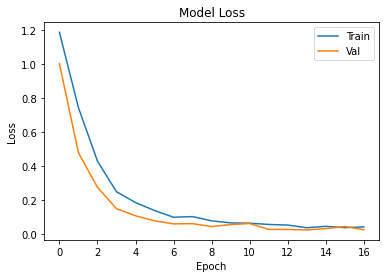

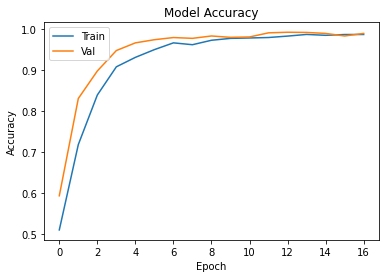

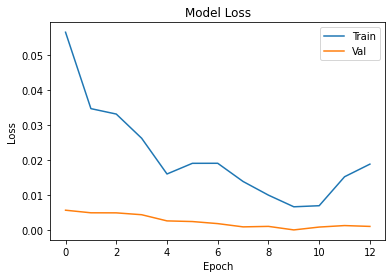

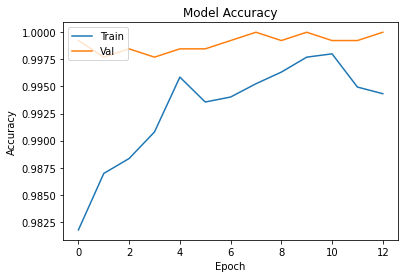

In [ ]:
plot_loss(model_glove_lstm_hist)
plot_acc(model_glove_lstm_hist)
plot_loss(model_glove_lstm_hist_b)
plot_acc(model_glove_lstm_hist_b)

In [ ]:
test_a = np.stack(test_lp['t_answer'], axis=0)
test_y = np.stack(test_lp['cat_level'], axis=0)
test_a_b = np.stack(test_lp_b['t_answer'], axis=0)
test_y_b = np.stack(test_lp_b['cat_level'], axis=0)
#df_confusion = confusion_matrix(model, test_a_b, test_y_b)

In [ ]:
#df_confusion

In [ ]:
score = model.evaluate(test_a_b, test_y_b, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.0016377189895138144
Test accuracy: 0.9993293285369873


In [ ]:
#model.save('/content/drive/My Drive/Depression_detect/model_glove_lstm_b.h5')
#model.save('model_glove_lstm_b.h5')
#with open('/content/drive/My Drive/Depression_detect/model_glove_lstm_b_hist.json', 'w') as f:
#    json.dump(str(model_glove_lstm_hist.history), f)

In [ ]:
def test_model(text,model):
    print(text)
    word_list = text_to_wordlist(text)
    sequences = tokenizer.texts_to_sequences([word_list])
    sequences_input = list(itertools.chain(*sequences))
    sequences_input =  pad_sequences([sequences_input], value=0, padding="post", maxlen=windows_size).tolist()
    print(sequences_input)
    input_a = np.asarray(sequences_input)
    pred = model.predict(input_a, batch_size=None, verbose=0, steps=None)
    predicted_class = np.argmax(pred)
    print(labels[predicted_class])

In [ ]:
text= "I want an ice cream and have some fries for lunch"
test_model(text, model)
sen = "I'm afraid of losing my work, I don't have any money"
test_model(sen, model)
sen = "I'm worried about my future, I'm afraid of it"
test_model(sen, model)
sen = "I am a graduate student"
test_model(sen, model)
sen = "I am getting married"
test_model(sen, model)
sen = "This party is great, I know lots of people"
test_model(sen, model)
sen = "I miss my parents, brothers and sisters"
test_model(sen, model)
sen = "I detest my horrible job"
test_model(sen, model)
sen = "I cannot handle this anymore"
test_model(sen, model)

I want an ice cream and have some fries for lunch
[[281, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
moderately severe
I'm afraid of losing my work, I don't have any money
[[1, 19, 1532, 1107, 63, 168, 0, 0, 0, 0]]
moderately severe
I'm worried about my future, I'm afraid of it
[[1, 19, 1, 19, 1532, 0, 0, 0, 0, 0]]
severe
I am a graduate student
[[856, 1350, 0, 0, 0, 0, 0, 0, 0, 0]]
severe
I am getting married
[[153, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
severe
This party is great, I know lots of people
[[944, 205, 9, 35, 37, 0, 0, 0, 0, 0]]
severe
I miss my parents, brothers and sisters
[[741, 211, 196, 0, 0, 0, 0, 0, 0, 0]]
moderately severe
I detest my horrible job
[[585, 61, 0, 0, 0, 0, 0, 0, 0, 0]]
severe
I cannot handle this anymore
[[185, 601, 360, 0, 0, 0, 0, 0, 0, 0]]
moderately severe


## MODEL 2  glove + 2LSTMs

In [ ]:
answer_inp = Input(shape=(windows_size, ))
embedding_size_glove = 100
answer_emb1 = Embedding(vocab_size_stop+1, embedding_size_glove, weights=[embedding_matrix_lp], input_length=windows_size, trainable=False)(answer_inp)


lstm1 = LSTM(embedding_size_glove, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)(answer_emb1)
lstm2 = LSTM(embedding_size_glove, dropout=0.2, recurrent_dropout=0.2)(lstm1)

X = Dropout(0.2)(lstm2)
bt = BatchNormalization()(X)
dense1 = Dense(units=256, activation="relu")(bt)

out = Dense(5,  activation='softmax')(dense1)

model_2lstm = Model(inputs=[answer_inp], outputs=[out])
model_2lstm.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
model_2lstm.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 10, 100)           158000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 100)           80400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2585

In [ ]:
model_glove_2lstm_b_hist = model_2lstm.fit(train_a_b, train_y_b, validation_data=(dev_a_b, dev_y_b), epochs=30, batch_size=64, shuffle=True, callbacks=[early_stopping])

Epoch 1/30
102/102 [==============================] - 6s 60ms/step - loss: 1.2304 - accuracy: 0.4986 - val_loss: 1.3881 - val_accuracy: 0.4743
Epoch 2/30
102/102 [==============================] - 6s 56ms/step - loss: 1.0308 - accuracy: 0.5906 - val_loss: 1.2718 - val_accuracy: 0.6314
Epoch 3/30
102/102 [==============================] - 6s 56ms/step - loss: 0.9038 - accuracy: 0.6464 - val_loss: 1.1147 - val_accuracy: 0.6414
Epoch 4/30
102/102 [==============================] - 6s 56ms/step - loss: 0.7827 - accuracy: 0.6913 - val_loss: 0.7932 - val_accuracy: 0.7203
Epoch 5/30
102/102 [==============================] - 6s 56ms/step - loss: 0.6775 - accuracy: 0.7327 - val_loss: 0.6589 - val_accuracy: 0.7387
Epoch 6/30
102/102 [==============================] - 6s 57ms/step - loss: 0.5912 - accuracy: 0.7656 - val_loss: 0.6156 - val_accuracy: 0.7441
Epoch 7/30
102/102 [==============================] - 6s 57ms/step - loss: 0.4902 - accuracy: 0.8092 - val_loss: 0.4502 - val_accuracy: 0.8268

In [ ]:
model_2lstm.save('model_2lstm_b.h5')

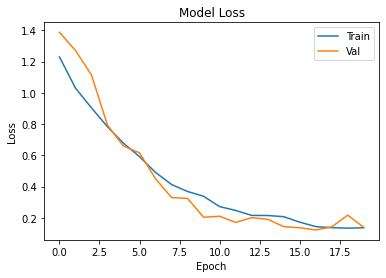

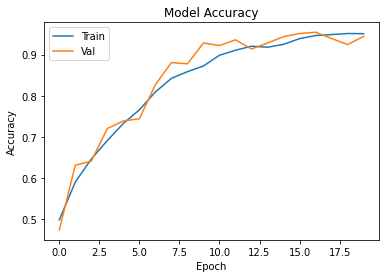

In [ ]:
plot_loss(model_glove_2lstm_b_hist)
plot_acc(model_glove_2lstm_b_hist)


In [ ]:

score = model_2lstm.evaluate(test_a_b, test_y_b, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.159211203455925
Test accuracy: 0.9423205852508545


In [ ]:
df_confusion = confusion_matrix(model_2lstm, test_a_b, test_y_b)

In [ ]:
df_confusion

col_0,none,mild,moderate,moderately severe,severe
row_0,,,,,
none,528,14,37,0,1
mild,0,93,5,0,0
moderate,2,0,545,0,3
moderately severe,1,1,16,97,0
severe,0,0,6,0,142


In [ ]:
#model_2lstm.save('/content/drive/My Drive/Depression_detect/model_glove_2lstm_b.h5')
model_2lstm.save('model_glove_2lstm_b.h5')
#with open('/content/drive/My Drive/Depression_detect/model_glove_2lstm_b_hist.json', 'w') as f:
#    json.dump(model_glove_2lstm_b_hist.history, f)

In [ ]:
sen = "All is going right with the party, I'm happy to know new people"
test_model(sen, model_2lstm)
sen = "I want an ice cream and have some fries for lunch"
test_model(sen, model_2lstm)
sen = "I'm afraid of losing my work, I don't have any money"
test_model(sen, model_2lstm)
sen = "I'm worried about my future, I'm afraid of it"
test_model(sen, model_2lstm)
sen = "My father loves me"
test_model(sen, model_2lstm)

All is going right with the party, I'm happy to know new people
[[92, 83, 944, 1, 19, 115, 9, 137, 37, 0]]
moderate
I want an ice cream and have some fries for lunch
[[281, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
moderately severe
I'm afraid of losing my work, I don't have any money
[[1, 19, 1532, 1107, 63, 168, 0, 0, 0, 0]]
none
I'm worried about my future, I'm afraid of it
[[1, 19, 1, 19, 1532, 0, 0, 0, 0, 0]]
none
My father loves me
[[138, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
mild


## MODEL 3 Bidirectional LSTM

In [ ]:
# main model
answer_inp = Input(shape=(windows_size, ))
embedding_size_glove = 100
answer_emb1 = Embedding(vocab_size_stop+1, embedding_size_glove, weights=[embedding_matrix_lp], input_length=windows_size, trainable=False)(answer_inp)


bi_lstm =  Bidirectional (LSTM (embedding_size_glove,return_sequences=True,dropout=0.50),merge_mode='concat')(answer_emb1)
model_bi1 = TimeDistributed(Dense(embedding_size_glove,activation='relu'))(bi_lstm) #TimeDistributed method is used to apply a Dense layer to each of the time-steps independently. We used Dropout and l2_reg regularizers to reduce overfitting.
model_bi2 = Flatten()(model_bi1)
model_bi3 = Dense(256,activation='relu')(model_bi2)
output = Dense(5,activation='softmax')(model_bi3)
model_bi = Model(answer_inp,output)
model_bi.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
model_bi.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 10, 100)           158000    
_________________________________________________________________
bidirectional (Bidirectional (None, 10, 200)           160800    
_________________________________________________________________
time_distributed (TimeDistri (None, 10, 100)           20100     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1000)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               256256    
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 1285

In [ ]:
model_glove_bilstm = model_bi.fit(train_a_b, train_y_b, validation_data=(dev_a_b, dev_y_b), epochs=30, batch_size=64, shuffle=True, callbacks=[early_stopping])

Epoch 1/30
102/102 [==============================] - 4s 38ms/step - loss: 1.2881 - accuracy: 0.4690 - val_loss: 1.2254 - val_accuracy: 0.4774
Epoch 2/30
102/102 [==============================] - 3s 31ms/step - loss: 1.1589 - accuracy: 0.5376 - val_loss: 1.0626 - val_accuracy: 0.5977
Epoch 3/30
102/102 [==============================] - 3s 31ms/step - loss: 1.0636 - accuracy: 0.5757 - val_loss: 0.9505 - val_accuracy: 0.6138
Epoch 4/30
102/102 [==============================] - 3s 31ms/step - loss: 0.9458 - accuracy: 0.6281 - val_loss: 0.8172 - val_accuracy: 0.6927
Epoch 5/30
102/102 [==============================] - 3s 31ms/step - loss: 0.8394 - accuracy: 0.6691 - val_loss: 0.7431 - val_accuracy: 0.7119
Epoch 6/30
102/102 [==============================] - 3s 31ms/step - loss: 0.7731 - accuracy: 0.6944 - val_loss: 0.6842 - val_accuracy: 0.7142
Epoch 7/30
102/102 [==============================] - 3s 31ms/step - loss: 0.6781 - accuracy: 0.7344 - val_loss: 0.5505 - val_accuracy: 0.7854

In [ ]:
model_bi.save('model_bilstm_a_b.h5')

In [ ]:
# evaluate the model
score = model_bi.evaluate(test_a_b, test_y_b, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.10792694985866547
Test accuracy: 0.9570757746696472


### Model 4 Using BiGRU 

In [ ]:
from sklearn.metrics import roc_auc_score

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, SpatialDropout1D, concatenate
from tensorflow.keras.layers import GRU, Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.callbacks import Callback

### AUC - ROC curve is a performance measurement for classification problem at various thresholds settings.

In [ ]:
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: %d - score: %.6f \n" % (epoch+1, score))

In [ ]:
# main model
answer_inp = Input(shape=(windows_size, ))
embedding_size_glove = 100
answer_emb1 = Embedding(vocab_size_stop+1, embedding_size_glove, weights=[embedding_matrix_lp], input_length=windows_size, trainable=False)(answer_inp)

x = SpatialDropout1D(0.2)(answer_emb1)
x = Bidirectional(GRU(embedding_size_glove, return_sequences=True))(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
conc = concatenate([avg_pool, max_pool])
outp = Dense(5, activation="softmax")(conc)
    
model_gru = Model(inputs=answer_inp, outputs=outp)
model_gru.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model_gru.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 10, 100)      158000      input_4[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d (SpatialDropo (None, 10, 100)      0           embedding_3[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 10, 200)      121200      spatial_dropout1d[0][0]          
____________________________________________________________________________________________

In [ ]:
batch_size = 64
epochs = 30
RocAuc = RocAucEvaluation(validation_data=(dev_a,dev_y), interval=1)

In [ ]:
hist = model_gru.fit(train_a, train_y, batch_size=batch_size, epochs=epochs, validation_data=(dev_a, dev_y),
                 callbacks=[RocAuc], verbose=2)

Epoch 1/30

 ROC-AUC - epoch: 1 - score: 0.790137 

163/163 - 5s - loss: 1.3050 - accuracy: 0.4414 - val_loss: 1.1756 - val_accuracy: 0.5576
Epoch 2/30

 ROC-AUC - epoch: 2 - score: 0.849566 

163/163 - 4s - loss: 1.1431 - accuracy: 0.5340 - val_loss: 1.0106 - val_accuracy: 0.6286
Epoch 3/30

 ROC-AUC - epoch: 3 - score: 0.896192 

163/163 - 4s - loss: 0.9942 - accuracy: 0.6090 - val_loss: 0.8766 - val_accuracy: 0.6799
Epoch 4/30

 ROC-AUC - epoch: 4 - score: 0.935397 

163/163 - 4s - loss: 0.8476 - accuracy: 0.6785 - val_loss: 0.7256 - val_accuracy: 0.7510
Epoch 5/30

 ROC-AUC - epoch: 5 - score: 0.956841 

163/163 - 4s - loss: 0.7111 - accuracy: 0.7462 - val_loss: 0.5987 - val_accuracy: 0.7994
Epoch 6/30

 ROC-AUC - epoch: 6 - score: 0.974281 

163/163 - 4s - loss: 0.5747 - accuracy: 0.8011 - val_loss: 0.4895 - val_accuracy: 0.8517
Epoch 7/30

 ROC-AUC - epoch: 7 - score: 0.985568 

163/163 - 4s - loss: 0.4559 - accuracy: 0.8512 - val_loss: 0.3821 - val_accuracy: 0.8810
Epoch 8/30

 

In [ ]:
model_gru.save('model_gru.h5')

In [ ]:
# evaluate the model
score = model_gru.evaluate(test_a_b, test_y_b, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.012290838174521923
Test accuracy: 0.9973172545433044


### CNN

In [ ]:
filter_sizes = [1,2,3,5]
num_filters = 36
answer_inp = Input(shape=(windows_size, ))
embedding_size_glove = 100
answer_emb1 = Embedding(vocab_size_stop+1, embedding_size_glove, weights=[embedding_matrix_lp], input_length=windows_size, trainable=False)(answer_inp)
x = Reshape((windows_size, embedding_size_glove, 1))(answer_emb1)
maxpool_pool = []
for i in range(len(filter_sizes)):
  conv = Conv2D(num_filters, kernel_size=(filter_sizes[i], embedding_size_glove),kernel_initializer='he_normal', activation='elu')(x)
  maxpool_pool.append(MaxPool2D(pool_size=(windows_size - filter_sizes[i] + 1, 1))(conv))

z = Concatenate(axis=1)(maxpool_pool)   
z = Flatten()(z)
z = Dropout(0.1)(z)

outp = Dense(5, activation="softmax")(z)

model = Model(inputs=answer_inp, outputs=outp)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 10, 100)      158000      input_5[0][0]                    
__________________________________________________________________________________________________
reshape (Reshape)               (None, 10, 100, 1)   0           embedding_4[0][0]                
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 10, 1, 36)    3636        reshape[0][0]                    
____________________________________________________________________________________________

In [ ]:
model_cnn =  model.fit(train_a, train_y, batch_size=64, epochs=30, validation_data=(dev_a, dev_y), verbose=2,callbacks=[early_stopping])

Epoch 1/30
163/163 - 2s - loss: 1.2497 - accuracy: 0.4758 - val_loss: 1.0099 - val_accuracy: 0.6084
Epoch 2/30
163/163 - 2s - loss: 0.8777 - accuracy: 0.6756 - val_loss: 0.7910 - val_accuracy: 0.7308
Epoch 3/30
163/163 - 3s - loss: 0.6571 - accuracy: 0.7814 - val_loss: 0.5944 - val_accuracy: 0.8287
Epoch 4/30
163/163 - 3s - loss: 0.4910 - accuracy: 0.8544 - val_loss: 0.4855 - val_accuracy: 0.8565
Epoch 5/30
163/163 - 2s - loss: 0.3591 - accuracy: 0.9083 - val_loss: 0.3600 - val_accuracy: 0.9060
Epoch 6/30
163/163 - 2s - loss: 0.2692 - accuracy: 0.9374 - val_loss: 0.2797 - val_accuracy: 0.9290
Epoch 7/30
163/163 - 2s - loss: 0.2024 - accuracy: 0.9584 - val_loss: 0.2343 - val_accuracy: 0.9415
Epoch 8/30
163/163 - 2s - loss: 0.1591 - accuracy: 0.9703 - val_loss: 0.2162 - val_accuracy: 0.9367
Epoch 9/30
163/163 - 2s - loss: 0.1232 - accuracy: 0.9799 - val_loss: 0.1563 - val_accuracy: 0.9655
Epoch 10/30
163/163 - 2s - loss: 0.0977 - accuracy: 0.9873 - val_loss: 0.1363 - val_accuracy: 0.9707

In [ ]:
model.save('model_cnn.h5')

In [ ]:
# evaluate the model
score = model.evaluate(test_a, test_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.04468998685479164
Test accuracy: 0.9865715503692627


## CNN + LSTM (Hybrid Model)

In [ ]:
lstm_cnn = Sequential()
lstm_cnn.add(Embedding(vocab_size_stop+1, 100,weights=[embedding_matrix_lp],input_length=windows_size, trainable=False))
lstm_cnn.add(Dropout(0.2))
lstm_cnn.add(Conv1D(64, 5, activation='relu'))
lstm_cnn.add(MaxPooling1D(pool_size=4))
lstm_cnn.add(LSTM(100))
lstm_cnn.add(Dense(5, activation='softmax'))
lstm_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
## Fit train data
lstm_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 10, 100)           158000    
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 100)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 6, 64)             32064     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1, 64)             0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               66000     
_________________________________________________________________
dense_10 (Dense)             (None, 5)                 505       
Total params: 256,569
Trainable params: 98,569
Non-trainable params: 158,000
_____________________________________________

In [ ]:
hist = lstm_cnn.fit(train_a_b, train_y_b, validation_data=(dev_a_b, dev_y_b), epochs=30, batch_size=64, shuffle=True, callbacks=[early_stopping])

Epoch 1/30
102/102 [==============================] - 1s 11ms/step - loss: 1.3124 - accuracy: 0.4565 - val_loss: 1.2357 - val_accuracy: 0.5165
Epoch 2/30
102/102 [==============================] - 1s 7ms/step - loss: 1.1854 - accuracy: 0.5377 - val_loss: 1.0968 - val_accuracy: 0.5923
Epoch 3/30
102/102 [==============================] - 1s 7ms/step - loss: 1.0296 - accuracy: 0.6042 - val_loss: 0.9697 - val_accuracy: 0.6467
Epoch 4/30
102/102 [==============================] - 1s 7ms/step - loss: 0.8802 - accuracy: 0.6668 - val_loss: 0.8232 - val_accuracy: 0.6789
Epoch 5/30
102/102 [==============================] - 1s 7ms/step - loss: 0.7386 - accuracy: 0.7186 - val_loss: 0.7472 - val_accuracy: 0.7103
Epoch 6/30
102/102 [==============================] - 1s 7ms/step - loss: 0.6705 - accuracy: 0.7462 - val_loss: 0.6924 - val_accuracy: 0.7464
Epoch 7/30
102/102 [==============================] - 1s 7ms/step - loss: 0.5506 - accuracy: 0.7986 - val_loss: 0.5457 - val_accuracy: 0.7969
Epoch

In [ ]:
lstm_cnn.save('model_lstm_cnn.h5')

In [ ]:
# evaluate the model
score = lstm_cnn.evaluate(test_a_b, test_y_b, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.313639372587204
Test accuracy: 0.8893359899520874


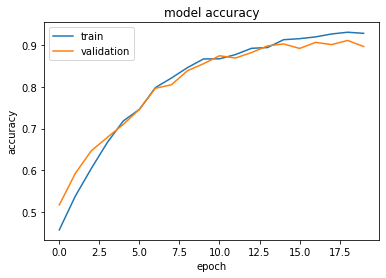

In [ ]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## BiLSTM + Attention

In [ ]:
lstm_units = 128
from tensorflow.keras.layers import RepeatVector,Permute,Multiply
in_text = Input(shape=(windows_size, ))
embedding_layer = Embedding(vocab_size_stop+1,
                        100,
                        weights=[embedding_matrix_lp],
                        input_length=windows_size,
                        trainable=False)
x = embedded_sequences = embedding_layer(in_text)
bilstm = Bidirectional(LSTM(lstm_units,return_sequences=True, dropout=0.3, recurrent_dropout=0.25))(x)  
attention = TimeDistributed(Dense(1,activation='tanh'))(bilstm)
attention = Flatten()(attention)
attention = Activation('softmax')(attention)
attention = RepeatVector(2*lstm_units)(attention)
attention = Permute([2, 1])(attention)
sent_representation = Multiply()([bilstm,attention])
out_text = Lambda(lambda xin: K.sum(xin, axis= 1), output_shape=(2*lstm_units,), name='sent')(sent_representation) 

output_ = Dense(5, activation='softmax')(out_text) 

bilstm_attn = Model(inputs=in_text, outputs= output_) 
bilstm_attn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
bilstm_attn.summary()

NameError: ignored

In [ ]:
history = bilstm_attn.fit(train_a_b, train_y_b, validation_data=(dev_a_b, dev_y_b), epochs=30, batch_size=64, shuffle=True)

In [ ]:
bilstm_attn.save('model_bilstm_attn.h5')

In [ ]:
# evaluate the model
score = bilstm_attn.evaluate(test_a, test_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
#app.py is backend while home.html,predict.html are frontend

from flask import Flask,render_template,request

import itertools
import pickle
#from sklearn.metrics import roc_auc_score
from tensorflow.keras.models import Model,load_model
#from tensorflow.keras.preprocessing.sequence import pad_sequences
#from tensorflow.keras.layers import Input,LSTM,BatchNormalization,Flatten,Bidirectional,SpatialDropout1D,Dense
#from tensorflow.keras.layers import Embedding,GRU,GlobalAveragePooling1D,concatenate,GlobalMaxPooling1D
#from tensorflow.keras.callbacks import Callback,ModelCheckpoint,EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
#import argparse
import regex as re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
wordnet_lemmatizer = WordNetLemmatizer()
# we can call a web page using render template
#to initiaize flask class
import pandas as pd
app=Flask(__name__)

windows_size= 10
vocab_size_stop= 1579
embedding_size_glove=100
vocab_size= 1484

#embedding_matrix_lp=np.load('embedding_matr.npy')
def text_to_wordlist(text, remove_stopwords=True, stem_words=False):    
    # Clean the text, with the option to remove stopwords and to stem words.
    
    # Convert words to lower case and split them
    text = text.lower().split()

    # Optionally, remove stop words
    if remove_stopwords:
        stops = stopwords.words("english")
        text = [wordnet_lemmatizer.lemmatize(w) for w in text if not w in stops ]
        text = [w for w in text if w != "nan" ]
    else:
        text = [wordnet_lemmatizer.lemmatize(w) for w in text]
        text = [w for w in text if w != "nan" ]
    
    text = " ".join(text)

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    
    text = re.sub(r"\<", " ", text)
    text = re.sub(r"\>", " ", text)
    
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    
    # Optionally, shorten words to their stems
    if stem_words:
        text = text.split()
        stemmer = SnowballStemmer('english')
        stemmed_words = [stemmer.stem(word) for word in text]
        text = " ".join(stemmed_words)
    
    # Return a list of words
    return(text)

with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

def app_test(sentence,h5file_paths):
    sentence_stop_removed= text_to_wordlist(sentence)
    answer= tokenizer.texts_to_sequences(sentence_stop_removed)
    answer = list(itertools.chain(*answer))
    answer =  pad_sequences([answer], value=0, padding="post", maxlen=windows_size).tolist()
    answer = np.asarray(answer)
    
    model1= load_model(h5file_paths[0])
    model2= load_model(h5file_paths[1])
    model3= load_model(h5file_paths[2])
    model4= load_model(h5file_paths[3])
    model5= load_model(h5file_paths[4])
    model6= load_model(h5file_paths[5])
    model7= load_model(h5file_paths[6])
    model8= load_model(h5file_paths[7])

    model_pred1= np.argmax(model1.predict(answer))
    model_pred2= np.argmax(model2.predict(answer))
    model_pred3= np.argmax(model3.predict(answer))
    model_pred4= np.argmax(model4.predict(answer))
    model_pred5= np.argmax(model5.predict(answer))
    model_pred6= np.argmax(model6.predict(answer))
    model_pred7= np.argmax(model7.predict(answer))
    model_pred8= np.argmax(model8.predict(answer))

    model_prediction= np.round_( (model_pred1+model_pred2+model_pred3+model_pred4+model_pred5+model_pred6+model_pred7+model_pred8)/(len(h5file_paths)))
    return model_prediction

In [ ]:
!pip install flask-ngrok


In [ ]:

from flask_ngrok import run_with_ngrok
from flask import Flask
app = Flask(__name__)
run_with_ngrok(app)   #starts ngrok when the app is run
@app.route("/")
def home():
    return render_template("home.html")
    #return "<h1>Running Flask on Google Colab!</h1>"
@app.route("/predict", methods=['GET','POST'])
def predict():
    print("i was here 1")
    model_prediction= 2

    #model_prediction= random.choice([1,2,4])
    if request.method == "POST":
        
        #print(gru_load_model.input,gru_load_model.output)
        sentence = request.form.get("answer123")
        
        #file_list=['model_2lstm_b.h5','model_bilstm_a_b.h5','model_cnn.h5','model_glove_2lstm_b.h5','model_glove_lstm.h5','model_glove_lstm_b.h5','model_gru.h5','model_lstm_cnn.h5']
        file_list=['model_2lstm_b.h5','model_bilstm_a_b.h5','model_cnn.h5','model_glove_2lstm_b.h5','model_glove_lstm.h5','model_glove_lstm_b.h5','model_gru.h5','model_lstm_cnn.h5']
        model_prediction= app_test(sentence,file_list)

        
    return render_template('predict.html',prediction =model_prediction)
  
app.run()
